# Computer Systems 2016/17

### Practice 3 - Time Comparison

#### Given a big array of numbers, say 30 million cells, we want to zero out all values below 2.5

###### Please excuse the occasional humor

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [2]:
import numpy as np
import time

numValues = 30000000
threshold = 2.5

start_time = time.time()

fakeDataVector = np.round(np.random.rand(numValues)*4 +1, decimals=2)

requiredTime_dataCreation = time.time()-start_time

resultVector = np.zeros(numValues)

fakeDataVector[0:27]


array([ 1.6 ,  1.12,  4.96,  2.9 ,  4.31,  2.34,  4.18,  2.68,  1.39,
        2.68,  3.47,  1.15,  1.29,  4.49,  2.02,  3.19,  3.57,  2.26,
        1.37,  1.27,  3.54,  1.78,  2.32,  1.6 ,  3.05,  4.52,  1.89])

#### Sequential

In [3]:
start_time = time.time()

resultVector = fakeDataVector

for i in range(len(fakeDataVector)):
    if(fakeDataVector[i]<=threshold):
        resultVector[i] = 0
            
            
requiredTime_sequential = time.time()-start_time
            
print("Sequential processing takes {:.3f} seconds".format(requiredTime_sequential))

Sequential processing takes 5.364 seconds


#### Vectorized

In [4]:
start_time = time.time()

resultVector = fakeDataVector

resultVector[resultVector<=threshold] = 0

requiredTime_vectorized = time.time()-start_time

print("Vectorized processing takes {:.3f} seconds".format(requiredTime_vectorized))

print("\n\nSo, the vectorized version takes only {:.2f} % of the time needed by the sequential one".
      format(requiredTime_vectorized/requiredTime_sequential*100))

Vectorized processing takes 0.144 seconds


So, the vectorized version takes only 2.69 % of the time needed by the sequential one


#### Pyspark

In [5]:
start_time = time.time()

fakeDataVector_rdd = sc.parallelize(fakeDataVector)

start_time_map = time.time()

resultVector_rdd = fakeDataVector_rdd.map(lambda x: 0 if x<=threshold else x )

end_time = time.time()

requiredTime_pyspark_overall = end_time-start_time
requiredTime_pyspark_rdd = start_time_map-start_time
requiredTime_pyspark_map = end_time-start_time_map

print("PySpark processing takes {:.3f} seconds".format(requiredTime_pyspark_overall))

if (requiredTime_pyspark_overall>requiredTime_vectorized):
    print("\n\nNo wait, what is this? \nSpark is taking {:.2f} % of the time needed by the vectorized code?".
      format(requiredTime_pyspark_overall/requiredTime_vectorized*100))
else:
    print("Damn that was unlucky... run the previous cells again please")

PySpark processing takes 1.010 seconds


No wait, what is this? 
Spark is taking 699.79 % of the time needed by the vectorized code?


#### Plot twist... Surprised?

.

.

.

.

.

.

.

.

.

.



#### There is, of course, a valid reason for this result... 

#### When using PySpark we are performing two operations
* Transforming the data into a RDD
* Mapping the elements into the desired values

#### Let's see how the computation time is distributed

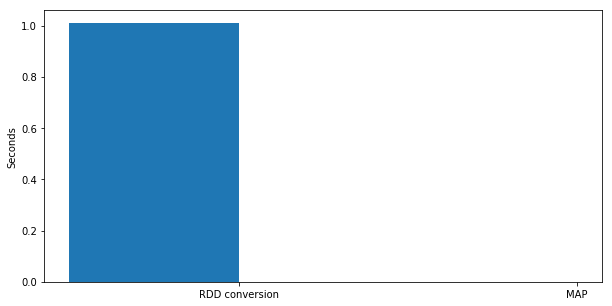

In [6]:
import matplotlib.pyplot as plt
import numpy as np


names = ['RDD conversion','MAP']

data = [requiredTime_pyspark_rdd,requiredTime_pyspark_map]

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
width=0.5

bins = map(lambda x: x-width/2,range(1,len(data)+1))
ax.bar(bins,data,width=width)
ax.set_xticks(map(lambda x: x, range(1,len(data)+1)))
ax.set_xticklabels(names)

plt.ylabel("Seconds")
plt.show()



#### There is no bar for map! Strange, perhaps we should look at the values, increasing the number of decimals...

In [7]:
print("The data transformation took \t{:.6f} seconds".format(requiredTime_pyspark_rdd))
print("The map operation took \t\t{:.6f} seconds".format(requiredTime_pyspark_map))

The data transformation took 	1.010128 seconds
The map operation took 		0.000107 seconds


#### We are witnessing a data conversion/loading delay
#### Always manage your data carefully, you don't want to waste most of the execution time transferring it

In [8]:
from pyspark.mllib.random import RandomRDDs

start_time = time.time()

fakeDataVector_rdd = RandomRDDs.uniformRDD(sc, numValues).map(lambda x: x*4+1)

start_time_map = time.time()

resultVector_rdd = fakeDataVector_rdd.map(lambda x: 0 if x<=threshold else x )

end_time = time.time()

requiredTime_pyspark_overall = end_time-start_time
requiredTime_pyspark_rdd = start_time_map-start_time
requiredTime_pyspark_map = end_time-start_time_map

print("Numpy random generator takes {:.3f} seconds".format(requiredTime_dataCreation))

print("\nGenerating the random numbers dyrectly into the RDD takes {:.3f} seconds".format(requiredTime_pyspark_rdd))

print("\n\nOverall PySpark processing takes {:.6f} seconds".format(requiredTime_pyspark_overall))

Numpy random generator takes 0.507 seconds

Generating the random numbers dyrectly into the RDD takes 0.065 seconds


Overall PySpark processing takes 0.064750 seconds


#### To sum up, if we focus only on the computation, we get:

In [9]:
print("Sequential \t{:.6f} seconds".format(requiredTime_sequential))

print("\n\nVectorized \t{:.6f} seconds \n\t\tImprovement of {:.2f} X over sequential".
      format(requiredTime_vectorized, 
             requiredTime_sequential/requiredTime_vectorized))

print("\n\nPySpark \t{:.6f} seconds \n\t\tImprovement of {:,.2f} X over vectorized \n\t\tImprovement of {:,.2f} X over sequential".
      format(requiredTime_pyspark_map, 
             requiredTime_vectorized/requiredTime_pyspark_map,
             requiredTime_sequential/requiredTime_pyspark_map))

Sequential 	5.363795 seconds


Vectorized 	0.144362 seconds 
		Improvement of 37.16 X over sequential


PySpark 	0.000172 seconds 
		Improvement of 839.80 X over vectorized 
		Improvement of 31,203.03 X over sequential


#### The performance gain of PySpark is HUGE... Any thougts on this result?

.

.

.

.

.

.

.

.

.

.


#### There is an important catch. All Spark Transformations are lazy evaluated, nothing is done until the result is needed by a Spark Action. Which means that the time we got is a meaningless number. It represents only the SparkContext "acknowleging" that at some point in the future that operation will have to be done.

#### Some Spark Transformations are:
* map(func)
* filter(func)
* union(otherDataset)
* intersection(otherDataset)
* groupByKey([numTasks])
* reduceByKey(func, [numTasks])

#### Some Spark Action are:
* reduce(func)
* collect()
* count()
* take(n)
* saveAsTextFile(path)
* foreach(func)

#### We can force the execution by performing a Take() action

In [10]:
from pyspark.mllib.random import RandomRDDs


fakeDataVector_rdd = RandomRDDs.uniformRDD(sc, numValues).map(lambda x: x*4+1)

start_time_map = time.time()

resultVector_rdd = fakeDataVector_rdd.map(lambda x: 0 if x<=threshold else x )
resultVector_rdd.take(1)

end_time = time.time()

requiredTime_pyspark_map = end_time-start_time_map

print("\n\nVectorized \t{:.6f} seconds \n\t\tImprovement of {:.2f} X over sequential".
      format(requiredTime_vectorized, 
             requiredTime_sequential/requiredTime_vectorized))

print("\n\nPySpark \t{:.6f} seconds \n\t\tImprovement of {:,.2f} X over vectorized \n\t\tImprovement of {:,.2f} X over sequential".
      format(requiredTime_pyspark_map, 
             requiredTime_vectorized/requiredTime_pyspark_map,
             requiredTime_sequential/requiredTime_pyspark_map))



Vectorized 	0.144362 seconds 
		Improvement of 37.16 X over sequential


PySpark 	0.473484 seconds 
		Improvement of 0.30 X over vectorized 
		Improvement of 11.33 X over sequential


### To sum up

#### If we take into account data creation & processing we get:

In [11]:
print("Sequential \t{:.6f} seconds".format(requiredTime_sequential+requiredTime_dataCreation))

print("\n\nVectorized \t{:.6f} seconds \n\t\tImprovement of {:.2f} X over sequential".
      format(requiredTime_vectorized+requiredTime_dataCreation, 
             (requiredTime_sequential+requiredTime_dataCreation)/(requiredTime_vectorized+requiredTime_dataCreation)))

print("\n\nPySpark \t{:.6f} seconds \n\t\tImprovement of {:,.2f} X over vectorized \n\t\tImprovement of {:,.2f} X over sequential".
      format(requiredTime_pyspark_overall,
             (requiredTime_vectorized+requiredTime_dataCreation)/requiredTime_pyspark_overall,
             (requiredTime_sequential+requiredTime_dataCreation)/requiredTime_pyspark_overall))

Sequential 	5.870652 seconds


Vectorized 	0.651219 seconds 
		Improvement of 9.01 X over sequential


PySpark 	0.064750 seconds 
		Improvement of 10.06 X over vectorized 
		Improvement of 90.67 X over sequential


### Fun fact

#### They all run on the same identical hardware... they just get much better at using it